In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

In [91]:
data = pd.read_csv('data/data.csv')
data.sample(5)

,date,variable,value
6949,2004-10-16 13:00:00,area_1,14.635
45026,2005-03-22 02:00:00,area_3,85.425
35279,2004-02-09 23:00:00,area_3,92.357
37334,2004-05-05 14:00:00,area_3,72.814
19086,2004-03-21 06:00:00,area_2,117.010


In [92]:
data['date']=pd.to_datetime(data['date'])

In [93]:
data = data.set_index(['date','variable'])


In [94]:
data = data.sort_index()

In [117]:
area1 = data.loc[idx[:,'area_1'],:].reset_index(level='variable',drop=True)
area1 = area1.loc[:area1[area1.value.isnull() == False].iloc[-1].name]
area1.value = area1.value.interpolate()

area2 = data.loc[idx[:,'area_2'],:].reset_index(level='variable',drop=True)
area2 = area2.loc[:area2[area2.value.isnull() == False].iloc[-1].name]
area2.value = area2.value.interpolate()

area3 = data.loc[idx[:,'area_3'],:].reset_index(level='variable',drop=True)
area3 = area3.loc[:area3[area3.value.isnull() == False].iloc[-1].name]
area3.value = area3.value.interpolate()

# area1.head(5)

In [118]:
area1

,value
date,
2004-01-01 00:00:00,16.853
2004-01-01 01:00:00,16.450
2004-01-01 02:00:00,16.517
2004-01-01 03:00:00,16.873
2004-01-01 04:00:00,17.064
2004-01-01 05:00:00,17.727
2004-01-01 06:00:00,18.574
2004-01-01 07:00:00,19.355
2004-01-01 08:00:00,19.534


In [181]:
area1 = area3.resample('3D',closed = 'right').mean()

In [182]:
area1_logged = area1['value'].map(np.log)


In [183]:
area1_logged_diffed = area1_logged.diff()

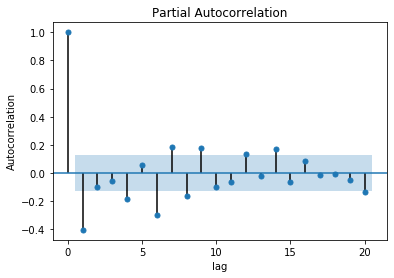

In [184]:
area1_logged_diffed = area1_logged.diff()
plot_pacf(area1_logged_diffed.dropna(), alpha=.05, lags=20,method='ols')  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [167]:
#data.loc[idx[:,'area_2'],:].unstack(1).value.plot()

In [168]:
#data.loc[idx[:,'area_1'],:].unstack(1).value.plot()

In [185]:
p = q = [1]
d = [0]
P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 

S = [6, 9, 14] # <-- let's pretend we have a couple of hypothesis 

In [186]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [187]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

In [188]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    predictions_best_model = results.get_prediction()
    mep = mean_absolute_percentage_error(series_[1:],np.exp(predictions_best_model.predicted_mean)[1:])
    
    # return the aic 
    return mep

In [189]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(area1_logged, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

CPU times: user 8.78 s, sys: 62.5 ms, total: 8.84 s
Wall time: 9.59 s


In [190]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
8,1,0,1,0,1,0,14,1714.676278
7,1,0,1,0,1,0,9,1755.554826
6,1,0,1,0,1,0,6,1785.837220
20,1,0,1,1,1,0,14,1797.128038
18,1,0,1,1,1,0,6,1800.772282


In [191]:
best_model = SARIMAX(area1_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(1, 1, 0, 17))

results = best_model.fit()
predictions_best_model = results.get_prediction()

In [145]:
area1.tail()

,value
date,
2005-05-10,15.538847
2005-05-13,13.615250
2005-05-16,13.768111
2005-05-19,13.184042
2005-05-22,13.196292


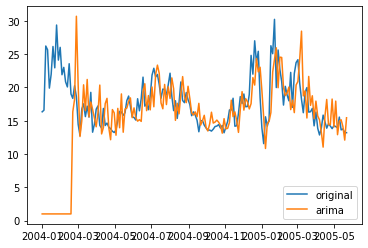

In [133]:
plt.plot(area1[-300:], label='original')
plt.plot(np.exp(predictions_best_model.predicted_mean[-300:]), label='arima')
plt.legend()
plt.show();

In [56]:
# train_1 = area1_logged[:-1]
# test_1 = area1_logged[-1:]

In [107]:
# mae_model = sm.tsa.statespace.SARIMAX(train_1,
#                                       order=(1, 0, 1),
#                                       seasonal_order=(0, 1, 0, 15),
#                                      enforce_stationarity=False,
#                                      enforce_invertibility=False)

# results = mae_model.fit()
# predictions_mae_model = results.get_forecast(steps=7)

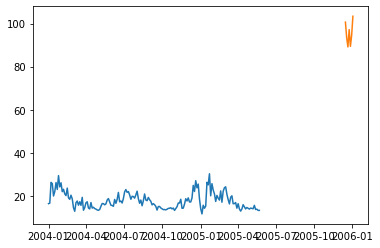

In [108]:
# plt.plot(area1[-1200:],label='original')
# plt.plot(np.exp(predictions_mae_model.predicted_mean), label='arima')
# plt.show();

In [41]:
# mean_absolute_percentage_error(area1[-168:],np.exp(predictions_mae_model.predicted_mean))

1018.4637945166232

In [149]:
area1_logged

date
2004-01-01    2.792981
2004-01-04    2.807943
2004-01-07    3.266075
2004-01-10    3.244234
2004-01-13    2.990122
2004-01-16    3.089628
2004-01-19    3.263356
2004-01-22    3.132561
2004-01-25    3.379562
2004-01-28    3.182050
2004-01-31    3.258344
2004-02-03    3.086384
2004-02-06    3.135621
2004-02-09    3.036600
2004-02-12    2.998965
2004-02-15    3.159069
2004-02-18    2.944666
2004-02-21    2.909334
2004-02-24    3.008011
2004-02-27    2.922329
2004-03-01    2.669683
2004-03-04    2.547852
2004-03-07    2.818367
2004-03-10    2.863720
2004-03-13    2.747933
2004-03-16    2.844143
2004-03-19    2.743535
2004-03-22    2.957558
2004-03-25    2.585363
2004-03-28    2.672584
                ...   
2005-02-24    3.094327
2005-02-27    3.166444
2005-03-02    3.184397
2005-03-05    3.025815
2005-03-08    2.901312
2005-03-11    2.784736
2005-03-14    2.960293
2005-03-17    2.993885
2005-03-20    2.790236
2005-03-23    2.793410
2005-03-26    2.823876
2005-03-29    2.654805
2005-0

In [192]:
mae_model = sm.tsa.statespace.SARIMAX(area1_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1,0, 14),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)

results = mae_model.fit()
predictions_mae_model = results.get_forecast(steps=4)

In [193]:
area1_pred = np.exp(predictions_mae_model.predicted_mean)

In [194]:
area1_pred

2005-12-15     95.347112
2005-12-18     98.589777
2005-12-21    102.239454
2005-12-24     88.786301
Freq: 3D, dtype: float64

In [195]:
pd.DataFrame(area1_pred).to_csv('daily_area3_pred.csv')

In [196]:
area1_pred

2005-12-15     95.347112
2005-12-18     98.589777
2005-12-21    102.239454
2005-12-24     88.786301
Freq: 3D, dtype: float64

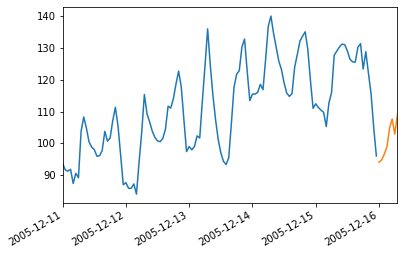

In [85]:

plt.plot(area3[-120:],label='original')
area1_pred.plot()
plt.show()

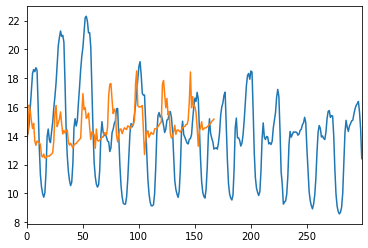

In [33]:
plt.plot(area1[-300:].reset_index(drop=True)['value'],label='original')
pd.read_csv('linear_model_data1.csv')['value'].plot()
plt.show()

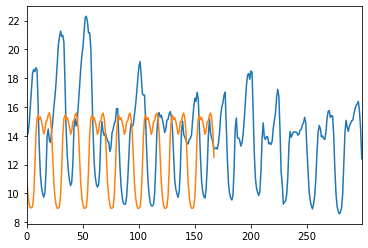

In [32]:
plt.plot(area1[-300:].reset_index(drop=True)['value'],label='original')

area1_pred.reset_index(drop=True).plot()
plt.show()

In [64]:
area2_pred = np.exp(predictions_mae_model.predicted_mean)


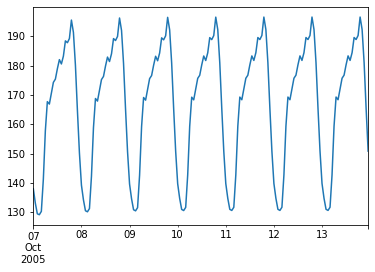

In [65]:
area2_pred.plot()

In [71]:
area3_pred = np.exp(predictions_mae_model.predicted_mean)


In [ ]:
area3_pred.plot()

In [ ]:
generate_submission_file(area1_pred,area2_pred,area3_pred)

In [72]:
predictions_area_1 = area1_pred
predictions_area_2 = area2_pred
predicitons_area_3 = area3_pred
#test_1 = pd.DataFrame(predictions_area_1)


In [73]:
test_1 = pd.DataFrame(predictions_area_1)
test_2 = pd.DataFrame(predictions_area_2)
test_3 = pd.DataFrame(predicitons_area_3)
test = pd.concat([test_1,test_2,test_3], axis=1)


In [74]:
test.columns = ['area_1','area_2','area_3']
test.index.name = 'date'
test = test.reset_index().melt(id_vars='date',value_vars=['area_1','area_2','area_3']).set_index('date')
test = test.dropna()
test = test.drop('variable',axis=1)
test.to_csv('submission.csv')

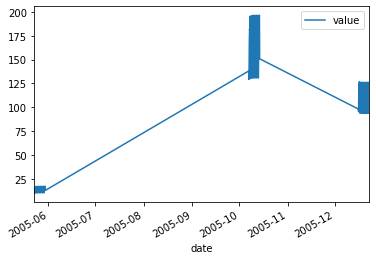

In [75]:
test.plot()